In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from utils import get_emotion_label 

EEG_RAW_DATA_DIR = 'archive/eeg_raw_data'
EEG_SMOOTH_DATA_DIR = 'archive/eeg_feature_smooth'

## DATA EXTRACTION

In [2]:
def open_raw(session, person=1):
    session_dir = os.path.join(EEG_RAW_DATA_DIR, str(session))
    all_mat_files = glob.glob(os.path.join(session_dir, '*.mat'))
    all_mat_files.sort(key=lambda path: int(os.path.basename(path).split('_')[0]))
    mat_file = sio.loadmat(all_mat_files[person-1])
    trials = []
    for key in mat_file.keys():
        if "_eeg" in key:
            trials.append(mat_file[key])
    return trials

In [3]:
def open_de(session, person=1):
    session_sm_dir = os.path.join(EEG_SMOOTH_DATA_DIR, str(session))
    all_sm_mat_files = glob.glob(os.path.join(session_sm_dir, '*.mat'))
    all_sm_mat_files.sort(key=lambda path: int(os.path.basename(path).split('_')[0]))
    sm_mat_file = sio.loadmat(all_sm_mat_files[person-1])
    trials_sm = []
    for key in sm_mat_file.keys():
        if "de_movingAve" in key:
            data = sm_mat_file[key]
            data = np.swapaxes(data, 0, 1)
            trials_sm.append(data)
    return trials_sm

In [4]:
SEED_RAW = open_raw(1, 1)
SEED_DE = open_de(1, 1)

## PARAMETERS

In [5]:
n_persons = 15
n_trials = 24
n_sessions = 3
n_channels = 62
sf = 200
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 31),
    'gamma': (31, 50)
}
band_names = list(bands.keys())

## EXTRACTION METHODS

In [6]:
import mne
from torcheeg import transforms
from scipy.signal import stft, welch, get_window
from scipy.fft import fft

In [7]:
def get_de_bandpass(signal, segment_len):
    picks = [i for i in range(n_channels)]
    ch_names = [f'CH{i}' for i in range(n_channels)]
    eeg_info = mne.create_info(ch_names=ch_names, sfreq=sf, ch_types='eeg')
    raw = mne.io.RawArray(signal, eeg_info)
    raw.filter(l_freq=0.1, h_freq=75.0, fir_design='firwin')
    
    data = []
    data.append(raw.copy().filter(1, 4, picks=picks, fir_design='firwin', verbose=False).get_data())
    data.append(raw.copy().filter(4, 8, picks=picks, fir_design='firwin', verbose=False).get_data())
    data.append(raw.copy().filter(8, 13, picks=picks, fir_design='firwin', verbose=False).get_data())
    data.append(raw.copy().filter(14, 31, picks=picks, fir_design='firwin', verbose=False).get_data())
    data.append(raw.copy().filter(31, 50, picks=picks, fir_design='firwin', verbose=False).get_data())

    _, n_samples = data[0].shape
    window_len = int(segment_len * sf)
    no_windows = n_samples // window_len
    
    features = []
    for w in range(no_windows):
        start = w * window_len
        end = start + window_len

        de_features = np.zeros((n_channels, len(bands)))
        for b in range(5):
            signal = data[b][:, start:end]
            var = np.var(signal, axis=1)
            de_features[:, b] = 0.5 * np.log(2*np.pi*np.e * var)
        features.append(de_features)
    features = np.stack(features, axis=0)
    
    return features

In [15]:
def get_de_stft(signal, segment_len, stft_n, fs):
    ch_names = [f'CH{i}' for i in range(n_channels)]
    eeg_info = mne.create_info(ch_names=ch_names, sfreq=sf, ch_types='eeg')
    raw = mne.io.RawArray(signal, eeg_info)
    raw.filter(l_freq=0.1, h_freq=75.0, fir_design='firwin')

    band_starts = np.array([v[0] for v in bands.values()])
    band_ends   = np.array([v[1] for v in bands.values()])

    signal = raw.get_data()
    _, n_samples = signal.shape
    window_len = int(segment_len * fs)
    n_windows = n_samples // window_len
    n_bands = len(band_starts)

    f_start_idx = (np.array(band_starts) / fs * stft_n).astype(int)
    f_end_idx   = (np.array(band_ends)   / fs * stft_n).astype(int)

    window = get_window("hann", window_len)

    features = np.zeros((n_windows, n_channels, n_bands))
    
    for w in range(n_windows):
        start = w * window_len
        end = start + window_len
        segment = signal[:, start:end]

        segment = segment * window

        fft_data = fft(segment, n=stft_n, axis=1)
        mag_sq = np.abs(fft_data[:, :stft_n // 2]) ** 2

        for b in range(n_bands):
            low = f_start_idx[b]
            high = f_end_idx[b]

            band_energy = mag_sq[:, low:high+1].mean(axis=1)
            features[w, :, b] =  np.log2(100* band_energy + 1e-12)

    return features

In [27]:
def moving_average(x, window=3):
    pad = window - 1
    x_padded = np.pad(x, (pad, 0), mode='edge')
    kernel = np.ones(window) / window
    y = np.convolve(x_padded, kernel, mode='valid')
    return y

def smooth_features(features, window=5):
    smoothed = np.zeros_like(features)

    T, C, B = features.shape

    for c in range(C):
        for b in range(B):
            smoothed[:, c, b] = moving_average(features[:, c, b], window)

    return smoothed

In [28]:
de_data = get_de_bandpass(SEED_RAW[0], 4)
stft_data = get_de_stft(SEED_RAW[0], 4, 512, sf)

methods = {
    "SEED Dataset": SEED_DE[0],
    "Bandpass Method": de_data,
    "Bandpass Smooth Method": smooth_features(de_data), 
    "STFT Method": stft_data,
    "STFT Smooth Method": smooth_features(stft_data),
}

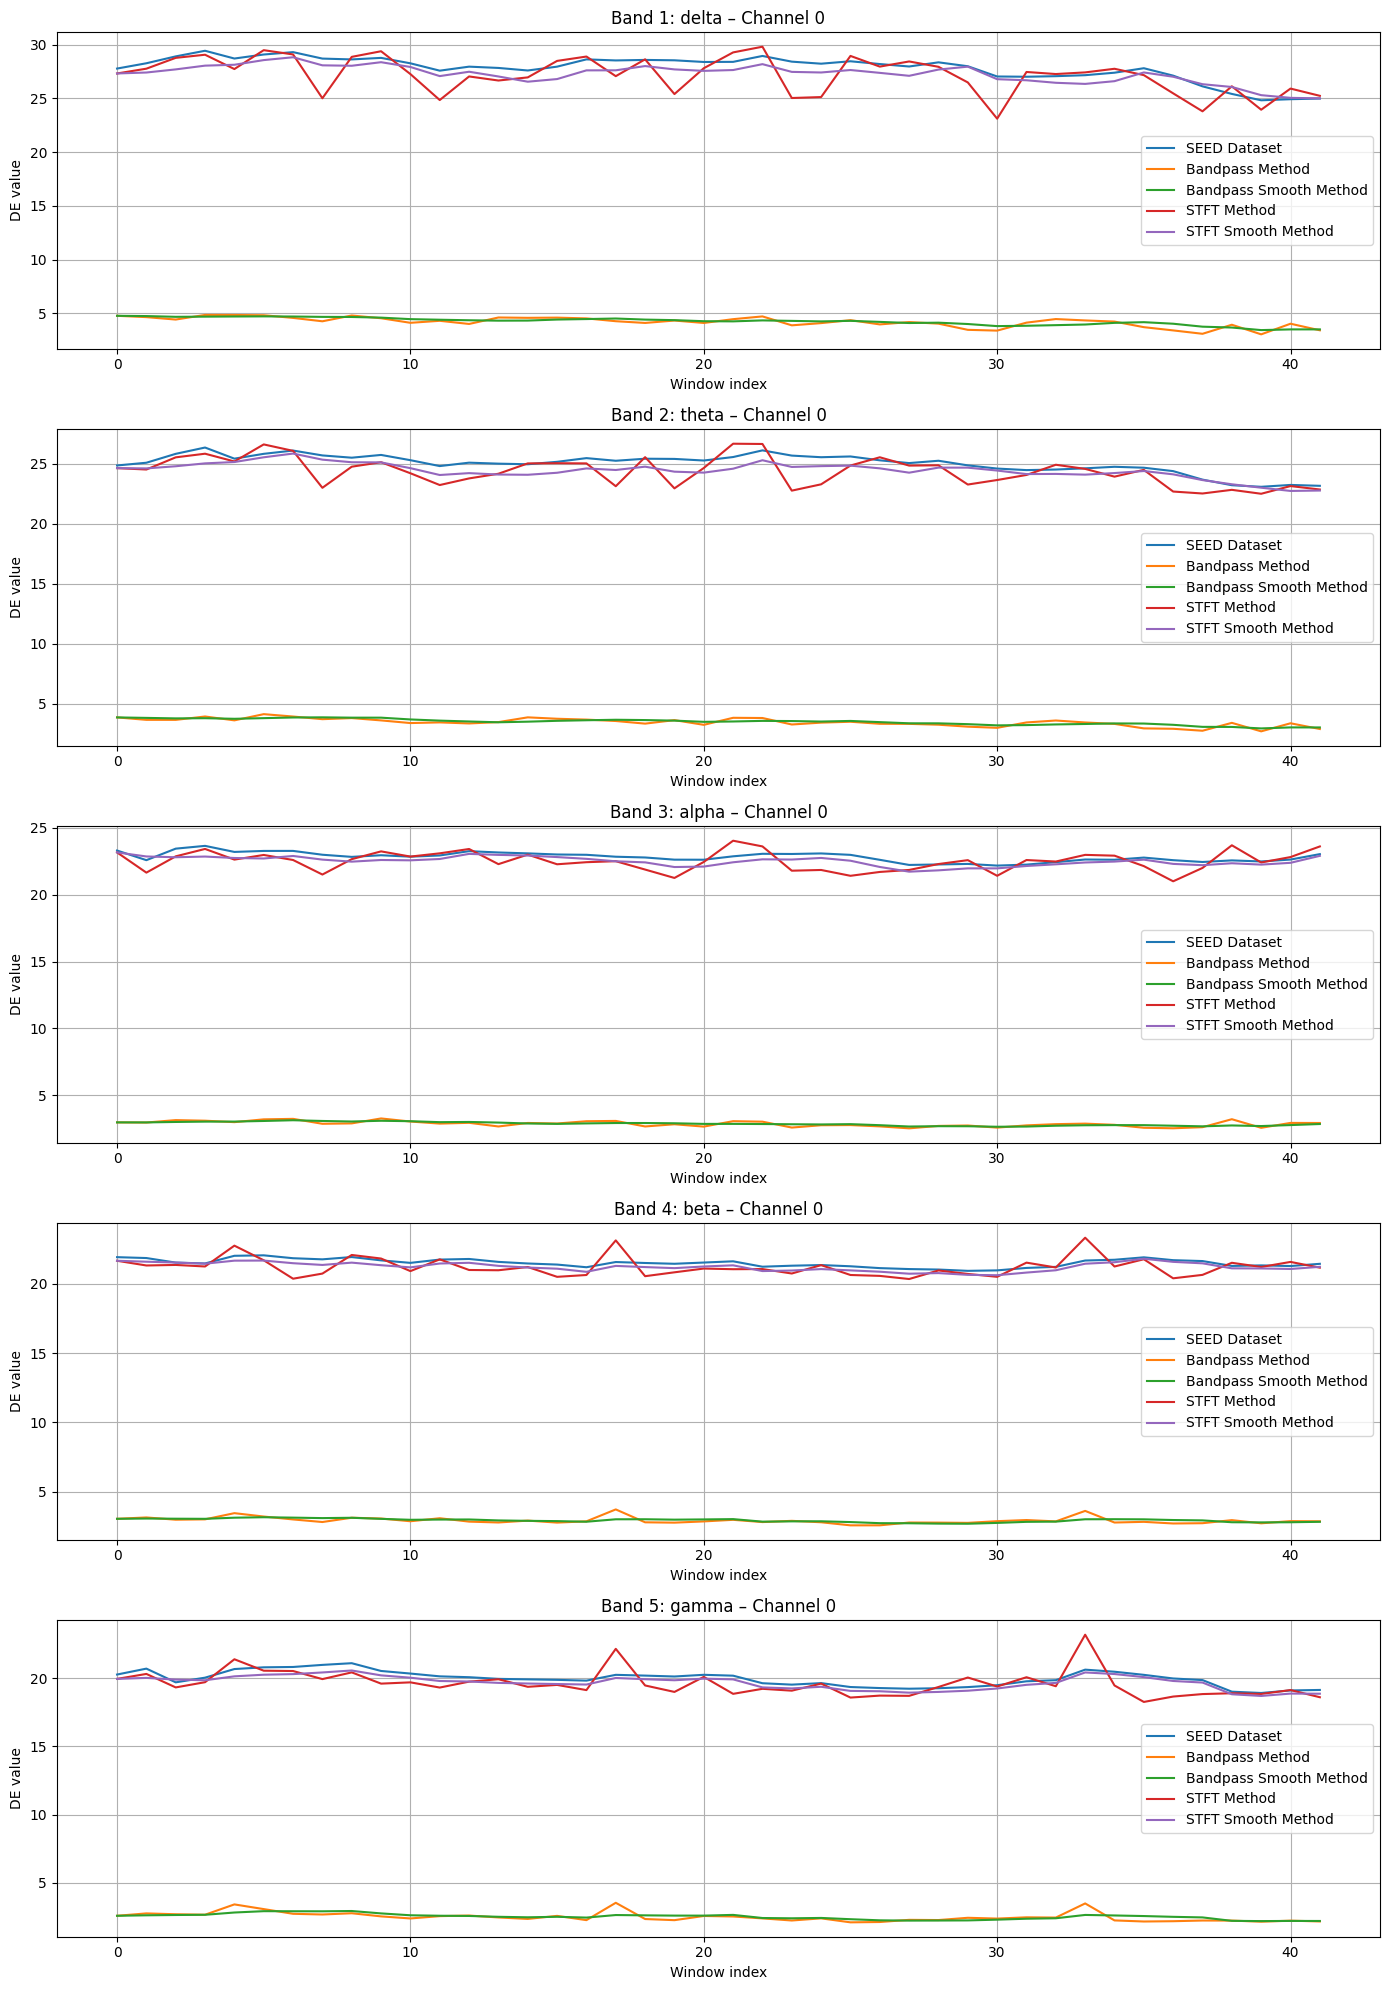

In [29]:
plt.figure(figsize=(14, 20))

channel = 0
num_bands = len(band_names)

for b in range(num_bands):
    plt.subplot(num_bands, 1, b + 1)
    
    for name, arr in methods.items():
        plt.plot(arr[:, channel, b], label=name, linewidth=1.5)
    
    plt.title(f"Band {b+1}: {band_names[b]} – Channel {channel}")
    plt.xlabel("Window index")
    plt.ylabel("DE value")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## DATA PREPARATION

In [179]:
def load_labels(label_file="./archive/eeg_labels.txt"):
    labels = np.loadtxt(label_file, dtype=int)
    if labels.shape != (3, 24):
        raise ValueError(f"Label file has incorrect shape: {labels.shape}, expected (3, 24)")
    return labels

LABELS = load_labels()

In [ ]:
def extract_bandpass(signal):
    return get_de_bandpass(signal, 1)

def extract_bandpass_smooth(signal):
    return smooth_features(get_de_bandpass(signal, 1))

def extract_stft(signal):
    return get_de_stft(signal, 1, fft_n=256)

def extract_stft_smooth(signal):
    return smooth_features(get_de_stft(signal, 1, fft_n=256))

In [210]:
def process_dataset(extract_fn, save_path):
    X = []
    y = []
    persons = []
    sessions = []

    for pers in range(n_persons):
        print(f"\n=== Processing Person {pers+1}/{n_persons} ===")
        for sess in range(n_sessions):
            session_trials = open_raw(sess+1, pers+1)
            print(f"  -> Session {sess+1}/{n_sessions}")
            for t, signal in enumerate(session_trials):
                label = LABELS[sess, t] # session, trial
                features = extract_fn(signal)
                features = np.asarray(features)

                n_windows = features.shape[0]
                for w in range(n_windows):
                    X.append(features[w]) # shape (62, 5)
                    y.append(label)
                    persons.append(pers)
                    sessions.append(sess)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)
    persons = np.array(persons, dtype=np.int32)
    sessions = np.array(sessions, dtype=np.int32)

    print(f"Created dataset with {X.shape[0]} samples")
    print("Sample shape:", X.shape[1:])

    np.savez_compressed(
        save_path,
        X=X,
        y=y,
        persons=persons,
        sessions=sessions
    )

    print(f"Saved dataset to: {save_path}")